## Real Datasets - MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import offsetbox
from sklearn.datasets import fetch_mldata
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import sklearn.neighbors as neigh_search
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score, accuracy_score, calinski_harabaz_score
import pandas as pd
import scipy.sparse as sps
from consensus_clustering.load_data import load_fuzzy_data
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
import sys
# from scipy.spatial import distance
# from copy import deepcopy
# from timeit import default_timer as timer
# from datetime import timedelta
import importlib
%matplotlib inline

In [2]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

# Use larger font
font = {'size'   : 12}
mpl.rc('font', **font)

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, labels, create_figure=True, title=None, ax=None, fig=None, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if create_figure:
        fig = plt.figure(figsize=figsize)

    if ax is None:
        ax = plt.subplot(111)

    ax.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        #plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
        ax.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)

            plt.xticks([]), plt.yticks([])
            ax.axis('off')
    if title is not None:
        #plt.title(title)
        ax.set_title(title)
    if savetitle:
        #plt.savefig(savetitle, transparent = True)
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        plt.savefig(savetitle + ".png", transparent = True, bbox_inches=extent)
        plt.savefig(savetitle + ".pdf", transparent = True, bbox_inches=extent)
        
def old_plot_embedding_cons_par(X, labels_cons, labels_par, title=None, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    
    #consensus
    ax1=plt.subplot(1, 2, 1)
    ax1.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax1.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels_cons[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax1.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Consensus Clustering')
        
    #parametersearch
    ax2=plt.subplot(1, 2, 2)
    ax2.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax2.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels_par[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax2.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.title('Highest NMI with Consensus Clustering')
    ax1.axis('off')
    ax2.axis('off')
    plt.tight_layout()
    if savetitle:
        plt.savefig(savetitle, transparent = True)

In [3]:
def plot_embedding_cons_par(X, 
                            labels_cons, labels_nmi, labels_anmi, 
                            title_cons=None, title_nmi=None, title_anmi=None, 
                            savetitle_cons=None, savetitle_nmi=None, savetitle_anmi=None, 
                            figsize=(16,6)):
    fig, axarr = plt.subplots(1, 3, figsize=figsize)
    plot_embedding(X, labels_cons, create_figure=False, title=title_cons, ax=axarr[0], fig=fig, figsize=None, savetitle=savetitle_cons)
    plot_embedding(X, labels_nmi,  create_figure=False, title=title_nmi,  ax=axarr[1], fig=fig, figsize=None, savetitle=savetitle_nmi)
    plot_embedding(X, labels_anmi, create_figure=False, title=title_anmi, ax=axarr[2], fig=fig, figsize=None, savetitle=savetitle_anmi)

In [4]:
np.shape(X)

(1083, 64)

In [5]:
def param_search_dbscan(data, k_consensus, recluster_what, recluster_how, eps_arr, min_pts_arr):
    num_objects = len(eps_arr)
    dbscan_objects = [None] * num_objects
    dbscan_obj = None

    print("Fit DBSCAN objects")

    # Fit DBSCAN objects
    for i, (eps, minPts) in enumerate(zip(eps_arr, min_pts_arr)):
        sys.stdout.write('\reps: {0}, minPts: {1}'.format(eps, minPts))
        dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
        dbscan_obj.fit()
        dbscan_objects[i] = dbscan_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*dbscan_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(dbscan_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, dbscan_objects, consensus_obj

In [6]:
def plot_results(data, cl_objects, nmi_arr, anmi_arr, consensus_obj, algorithm, arr_x, arr_y, savetitle = None):
    # Put labels in right order in to the labels array
    no_labels = [0] * len(data)
    clusterings_labels = []
    for obj in cl_objects:
        clusterings_labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
    print("Number of clusterings:", len(clusterings_labels))

    # Init plotting arrangement
    num_plots = len(cl_objects) #+ 2
    num_subplts_per_row = 6
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int) #+ 1
    num_x_param = len(arr_x)
    num_y_param = len(arr_y)
    if num_y_param > 1:
        num_subplts_per_row = num_x_param
        num_rows = num_y_param #+ 1
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row #-1
        ax.axis('off')
 
        ax.set_aspect('equal')
        ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i].astype(int), cmap='Set2', alpha=0.2)
        if algorithm == 'kmeans':
            ax.set_title('k = {:}, \nNMI = {:.3}\nANMI = {:.3}'.format(arr_x[i], nmi_arr[i], anmi_arr[i]))
        elif algorithm == 'meanshift':
            ax.set_title('bw = {:.3}, mindist = {:}\nNMI = {:.3}\nANMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i], anmi_arr[i]))
        elif algorithm == 'dbscan':
            ax.set_title('eps = {:.3}, minPts = {:}\nNMI = {:.3}\nANMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i], anmi_arr[i]))
        else:
            print("ERROR: Could not recognize algorithm parameter!")
            break
    plt.tight_layout()
    plt.show()
    if savetitle:
        fig.savefig(savetitle + ".png",transparent = True)
        fig.savefig(savetitle + ".pdf",transparent = True)

In [7]:
def old_anmi(consensus_obj, labels):
    ''' calculates nmi of every clustering with every other clustering. 
    here the clusterings we are considering are the set of clusterings 
    (with labelling in the label vector) and the consensus clustering (consensus_obj)
    
    Johannes: consensus-object already provides anmi-functionality. Refactor this to prevent errors
    in the ANMI-calculations below...
    '''
    obj_count=len(labels)+1 #number of clusterings plus the consensus clustering
    nmi_matrix=np.zeros((obj_count,obj_count)) #nmi matrix, note nmi is symmetric
    labels_all=np.concatenate((np.array(labels),np.reshape(consensus_obj.cluster_labels,(1,consensus_obj.cluster_labels.shape[0]))),axis=0)
    for j in range(obj_count):
        for k in range(j+1,obj_count):
            nmi_matrix[k,j]=consensus_obj.compute_nmi(labels_all[j],labels_all[k])
            nmi_matrix[j,k]=nmi_matrix[k,j]
        
    anmi_vector = np.sum(nmi_matrix,axis=0)/(obj_count-1)
    return nmi_matrix, anmi_vector

In [8]:
def anmi(consensus_obj, clustering_objects):
    ''' calculates nmi of every clustering with every other clustering. 
    Then, also calculates the vector of anmis of every clustering from that.
    '''
    n_clusterings = len(clustering_objects)
    nmi_matrix=np.zeros((n_clusterings, n_clusterings)) #nmi matrix, note nmi is symmetric
    for i, obj_i in enumerate(clustering_objects):
        for j, obj_j in enumerate(clustering_objects):
            if i <= j:
                nmi_matrix[i, j] = 0 if any((len(np.unique(np.array(obj_i.cluster_labels).astype(int))) == 1,
                                           len(np.unique(np.array(obj_j.cluster_labels).astype(int))) == 1)) else normalized_mutual_info_score(np.array(obj_i.cluster_labels).astype(int), np.array(obj_j.cluster_labels).astype(int))
                nmi_matrix[j, i] = nmi_matrix[i, j] # nmi is symmetric
    
    return nmi_matrix, np.mean(nmi_matrix, axis=0)

In [9]:
from sklearn.manifold import TSNE

In [10]:
params = dict(n_components=2, 
          perplexity=30.0, 
          early_exaggeration=5.0, 
          learning_rate=70.0, 
          n_iter=1000, 
          n_iter_without_progress=30, 
          min_grad_norm=1e-07, 
          metric='cityblock', 
          init='random', 
          verbose=0, 
          random_state=None, 
          method='barnes_hut', 
          angle=0.5
             )
tsne = TSNE(**params)
X_tsne = tsne.fit_transform(X)

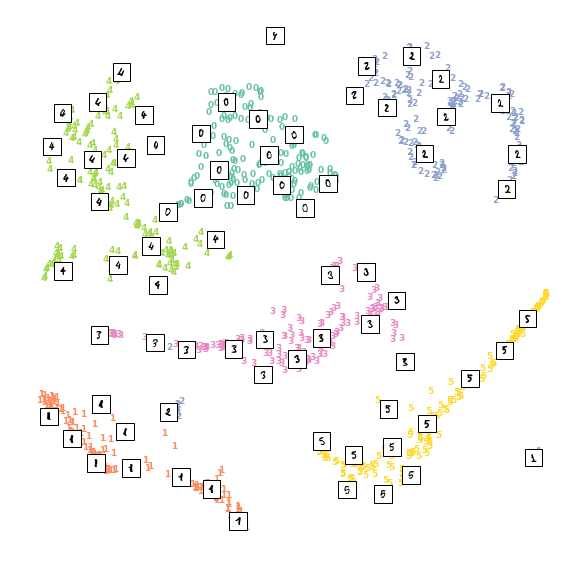

In [11]:
plot_embedding(X_tsne,y,figsize = (10,10))

In [12]:
# Set parameters:

# General
stride = 1
data = digits.data[::stride]
k_consensus = 6
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
n_eps = 6
n_min_pts = 6
eps_arr = np.linspace(5.0, 50.0, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 2
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

In [13]:
nmi_arr_db, cl_objects_db, consensus_obj_db = param_search_dbscan(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 50.0, minPts: 7
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:01.812492
Stopping cluster number was reached.
Current number of clusters: 6
Current minimum cluster distance: 0.18
Consensus clustering terminated.
Finished after 0:00:07.708124
ANMI (average normalized mutual information) of consensus with clusterings: 0.188
Calculate NMI's


## Check ANMI and NMI

In [14]:
nmi_matrix, anmi_vector_db = anmi(consensus_obj_db, cl_objects_db)
print(anmi_vector_db)
print('entry of anmi maximum: ', np.argmax(anmi_vector_db), ' and the anmi of that clustering with the rest: ', max(anmi_vector_db))

[ 0.          0.13920798  0.18699558  0.          0.          0.          0.
  0.14762069  0.18892917  0.          0.          0.          0.
  0.14877267  0.18775216  0.          0.          0.          0.
  0.14205352  0.19271455  0.          0.          0.          0.
  0.13296435  0.19189133  0.06333719  0.          0.          0.
  0.12661029  0.19050471  0.06333719  0.          0.        ]
entry of anmi maximum:  20  and the anmi of that clustering with the rest:  0.192714545729


In [15]:
len(anmi_vector_db)

36

Number of clusterings: 36


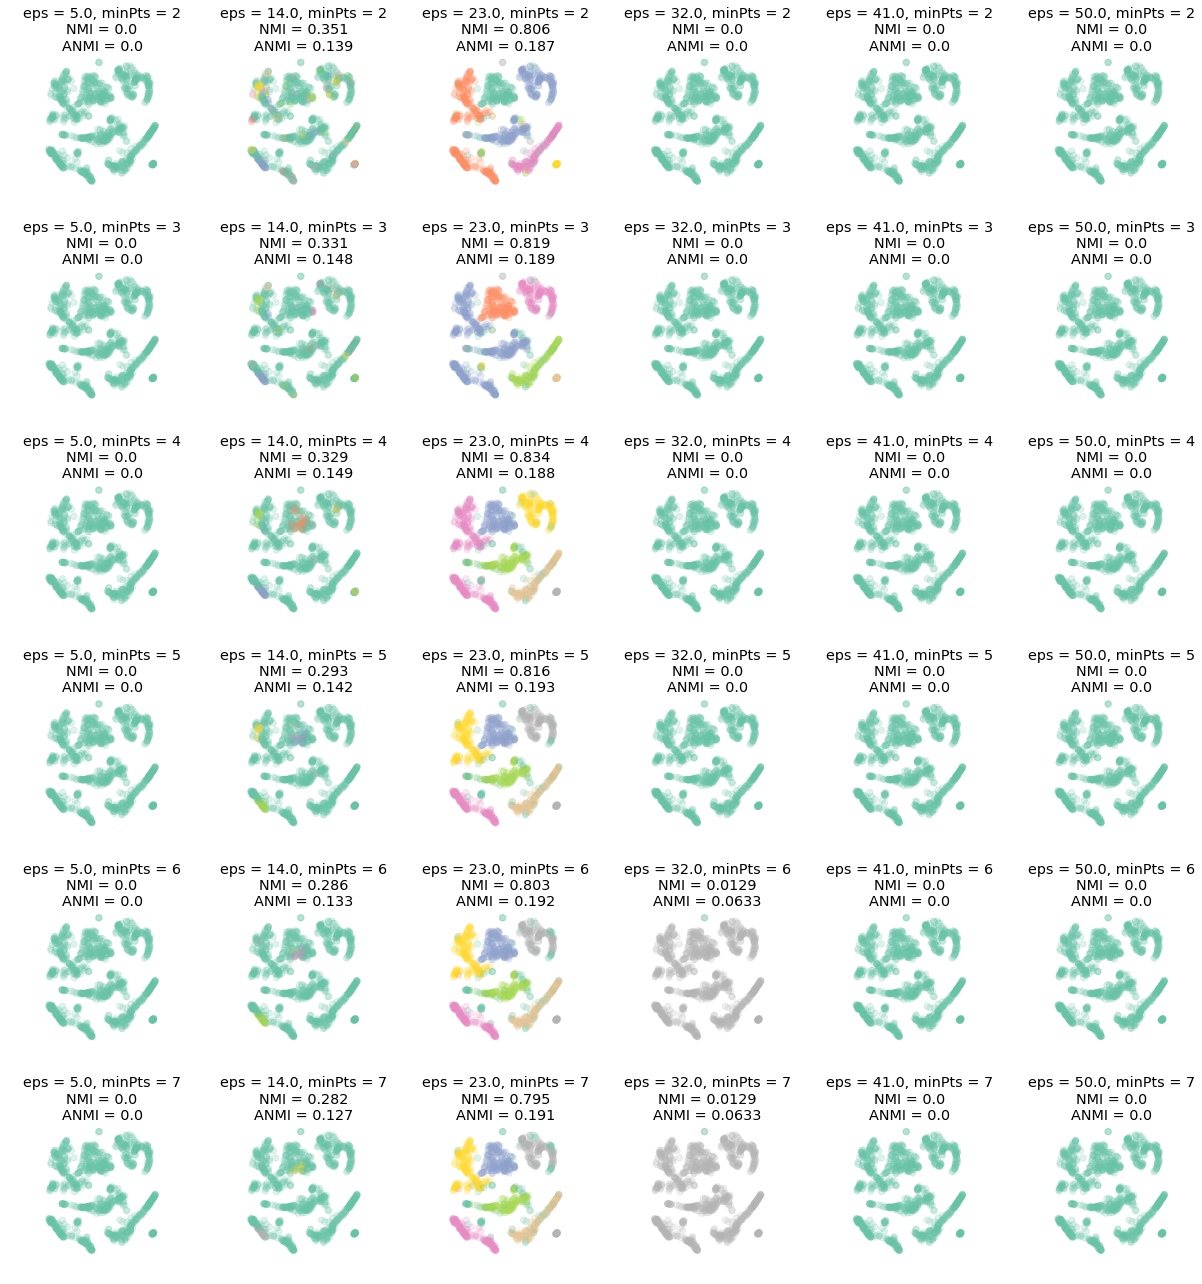

In [16]:
plot_results(data=X_tsne, cl_objects=cl_objects_db, nmi_arr=nmi_arr_db, anmi_arr=anmi_vector_db, consensus_obj=consensus_obj_db, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr,
            savetitle = 'img/mnist_dbscan_all')

## Consensus clustering result using DBSCAN vs highest NMI result with consensus

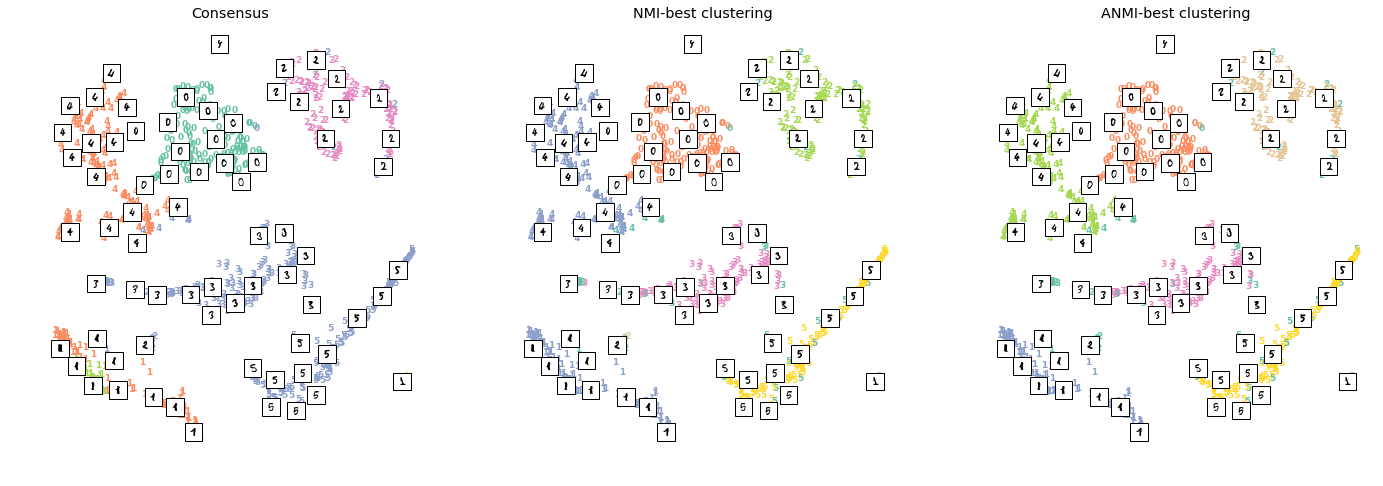

In [17]:
labels_nmi_best = np.array(cl_objects_db[np.argmax(nmi_arr_db)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_db[np.argmax(anmi_vector_db)].cluster_labels).astype(int)

plot_embedding_cons_par(X_tsne, 
                        consensus_obj_db.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        title_cons="Consensus", title_nmi="NMI-best clustering", title_anmi="ANMI-best clustering", 
                        figsize = (24,8), savetitle_cons='img/mnist_dbscan_consensus', savetitle_nmi='img/mnist_dbscan_NMI', savetitle_anmi='img/mnist_dbscan_ANMI')

In [18]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_db), " compared to the consensus result, the best parameters are then eps: ",mesh_eps.flatten()[np.argmax(nmi_arr_db)],", minpts: ", mesh_min_pts.flatten()[np.argmax(nmi_arr_db)])

The best parameter choice (given the chosen range) has NMI  0.833526902998  compared to the consensus result, the best parameters are then eps:  23.0 , minpts:  4


## Compute other clustering validity measures and render table

In [110]:
from itertools import combinations_with_replacement
from sklearn.metrics.pairwise import pairwise_distances

In [232]:
def dunn(labels, distances, method = 'absolute'):
    unique_labels = np.unique(labels)
    inter_maxes = []
    intra_mins = []
    if len(unique_labels)==1:
        return np.nan
    for i,j in combinations_with_replacement(unique_labels,2):
        if i==j:
            if method == 'absolute':
                val = np.max(distances[:,labels == i][labels == i,:])
            if method == 'mean':
                val = np.mean(distances[:,labels == i][labels == i,:])
            inter_maxes.append(val)            
        else:
            if method == 'absolute':
                val = np.min(distances[:,labels ==i][labels==j,:])
            if method == 'mean':
                val = np.mean(distances[:,labels ==i][labels==j,:])
            intra_mins.append(val)
    return np.min(intra_mins)/float(np.max(inter_maxes))   

In [242]:
def reformat_classes(arr):
    '''
    reindexes labels starting from 0 to n_labels
    in order to make them compatible with accuracy based scores
    '''
    arr = np.array(arr)
    counter = 0
    processed_labels = []
    out_arr = np.zeros(len(arr))
    for i,label in enumerate(arr):
        if label in processed_labels:
            continue
        else:
            out_arr[arr == label] = counter
            counter = counter +1
            processed_labels.append(label)
    return out_arr

fm = []
dn = []
dn2 = []
silhouette = []
#anmi_list = []
rand = []
acc = []
calinski = []
invalid = np.nan
for obj in cl_objects_db:
    #y_true = reformat_classes(consensus_obj_db.cluster_labels)
    #y_pred = reformat_classes(obj.cluster_labels)
    y_true = np.array(consensus_obj_db.cluster_labels)
    y_pred = np.array(obj.cluster_labels)
    try:
        silhouette.append(silhouette_score(X, y_pred))
    except:
        silhouette.append(invalid)    
    try:
        rand.append(adjusted_rand_score(y_true,y_pred))
    except:
        rand.append(invalid)        
    try:
        acc.append(accuracy_score(y_true,y_pred))
    except:
        acc.append(invalid)
    try:
        calinski.append(calinski_harabaz_score(X,y_pred))
    except:
        calinski.append(invalid)
    try:
        fm.append(fowlkes_mallows_score(y_true, y_pred))
    except:
        fm.append(invalid)
    dn.append(dunn(y_pred,pairwise_distances(X)))
    dn2.append(dunn(y_pred,pairwise_distances(X), method ='mean'))


silhouette = np.array(silhouette)
rand = np.array(rand)
acc = np.array(acc)
calinski = np.array(calinski)
dn = np.array(dn)
dn2 = np.array(dn2)
fm = np.array(fm)
#anmi_list = np.array(anmi_list)

In [243]:
nmi_df = pd.DataFrame(nmi_arr_db.reshape(n_min_pts,n_eps),columns=eps_arr, index=min_pts_arr)
calinski_df = pd.DataFrame(calinski.reshape(n_min_pts,n_eps),columns=eps_arr, index=min_pts_arr)
rand_df = pd.DataFrame(rand.reshape(n_min_pts,n_eps),columns=eps_arr, index=min_pts_arr)
silhouette_df = pd.DataFrame(silhouette.reshape(n_min_pts,n_eps),columns=eps_arr, index=min_pts_arr)
#anmi_df = pd.DataFrame(anmi_vector_db[:-1].reshape(n_min_pts,n_eps),columns=eps_arr, index=min_pts_arr)
anmi_df = pd.DataFrame(anmi_vector_db.reshape(n_min_pts,n_eps),columns=eps_arr, index=min_pts_arr)
dn_df = pd.DataFrame(dn.reshape(n_min_pts,n_eps),columns=eps_arr, index=min_pts_arr)
dn2_df = pd.DataFrame(dn2.reshape(n_min_pts,n_eps),columns=eps_arr, index=min_pts_arr)

result = pd.concat([nmi_df,silhouette_df,calinski_df,rand_df,anmi_df,dn_df,dn2_df], keys=['NMI', 'Silhouette', 'Calinski','Rand','ANMI','Dunn','Dunn2'])
result = result.reorder_levels([1,0]).sort_index()
#result.to_csv('mnist_dbscan_metrics.csv',float_format = '%.2f')
#result.loc[([2,3,4,5,6,7],['ANMI','NMI','Rand','Calinski','Silhouette']),:41].to_latex('mnist_dbscan_metrics.tex',float_format='%.2f')
#result.to_latex('mnist_dbscan_metrics.tex',float_format='%.2f')

In [244]:
result

5.0        14.0        23.0      32.0  41.0  50.0
2 ANMI         0.0   0.139208    0.186996  0.000000   0.0   0.0
  Calinski     NaN   4.336392   44.992876       NaN   NaN   NaN
  Dunn         NaN   0.181726    0.315691       NaN   NaN   NaN
  Dunn2        NaN   0.340917    0.546911       NaN   NaN   NaN
  NMI          0.0   0.350768    0.806482  0.000000   0.0   0.0
  Rand         0.0   0.124194    0.673885  0.000000   0.0   0.0
  Silhouette   NaN  -0.296618    0.037560       NaN   NaN   NaN
3 ANMI         0.0   0.147621    0.188929  0.000000   0.0   0.0
  Calinski     NaN   6.749090   66.254642       NaN   NaN   NaN
  Dunn         NaN   0.141004    0.190684       NaN   NaN   NaN
  Dunn2        NaN   0.411177    0.781204       NaN   NaN   NaN
  NMI          0.0   0.331210    0.818703  0.000000   0.0   0.0
  Rand         0.0   0.104398    0.677601  0.000000   0.0   0.0
  Silhouette   NaN  -0.333374    0.109817       NaN   NaN   NaN
4 ANMI         0.0   0.148773    0.187752  0.000000   0.0   0.0
  Calinski     NaN  10.464918  101.426289       NaN   NaN   NaN
  Dunn         NaN   0.141004    0.229675       NaN   NaN   NaN
  Dunn2        NaN   0.388818    0.925364       NaN   NaN   NaN
  NMI          0.0   0.328537    0.833527  0.000000   0.0   0.0
  Rand         0.0   0.094375    0.682516  0.000000   0.0   0.0
  Silhouette   NaN  -0.263134    0.172761       NaN   NaN   NaN
5 ANMI         0.0   0.142054    0.192715  0.000000   0.0   0.0
  Calinski     NaN  10.693024  123.865505       NaN   NaN   NaN
  Dunn         NaN   0.121074    0.201726       NaN   NaN   NaN
  Dunn2        NaN   0.419171    0.920064       NaN   NaN   NaN
  NMI          0.0   0.292601    0.816452  0.000000   0.0   0.0
  Rand         0.0   0.070543    0.596464  0.000000   0.0   0.0
  Silhouette   NaN  -0.256005    0.204104       NaN   NaN   NaN
6 ANMI         0.0   0.132964    0.191891  0.063337   0.0   0.0
  Calinski     NaN  12.652909  123.350002  2.337628   NaN   NaN
  Dunn         NaN   0.120376    0.201726  0.207687   NaN   NaN
  Dunn2        NaN   0.402634    0.919661  1.078402   NaN   NaN
  NMI          0.0   0.286258    0.803072  0.012853   0.0   0.0
  Rand         0.0   0.059692    0.586548 -0.001149   0.0   0.0
  Silhouette   NaN  -0.176247    0.202721  0.064628   NaN   NaN
7 ANMI         0.0   0.126610    0.190505  0.063337   0.0   0.0
  Calinski     NaN  21.551609  122.827277  2.337628   NaN   NaN
  Dunn         NaN   0.120376    0.201726  0.207687   NaN   NaN
  Dunn2        NaN   0.944849    0.927913  1.078402   NaN   NaN
  NMI          0.0   0.282032    0.794661  0.012853   0.0   0.0
  Rand         0.0   0.054502    0.578095 -0.001149   0.0   0.0
  Silhouette   NaN  -0.118148    0.200898  0.064628   NaN   NaN

### MEANSHIFT

In [22]:
def param_search_meanshift(data, k_consensus, recluster_what, recluster_how, bandwidth_arr, mindist_arr):
    num_objects = len(bandwidth_arr)
    ms_objects = [None] * num_objects
    ms_obj = None

    print("Fit Mean Shift objects")

    #Fit Mean Shift objects
    for i, (bandwidth, mindist) in enumerate(zip(bandwidth_arr, mindist_arr)):
        sys.stdout.write('\rbandwidth: {0}, mindist: {1}'.format(bandwidth, mindist))
        ms_obj = density.MeanShift(data, bandwidth=bandwidth, mindist=mindist, verbose=False)
        ms_obj.fit()
        ms_objects[i] = ms_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*ms_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(ms_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, ms_objects, consensus_obj

In [23]:
# Set parameters:

# General
stride = 1
data = digits.data[::stride]
k_consensus = 6
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
#n_eps = 6
#n_min_pts = 6
#eps_arr = np.linspace(5.0, 50.0, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
#min_pts_min = 4
#min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
#mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

n_bandwidths = 5
bw_arr = np.linspace(5, 15.0, n_bandwidths)
mindist_arr = np.linspace(0.02, 0.05, 2) #minimum distance
mesh_bw, mesh_mindist = np.meshgrid(bw_arr, mindist_arr)

In [24]:
nmi_arr_ms, cl_objects_ms, consensus_obj_ms = param_search_meanshift(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    bandwidth_arr = mesh_bw.flatten(),
    mindist_arr = mesh_mindist.flatten())

Fit Mean Shift objects
bandwidth: 15.0, mindist: 0.05
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:04.614139
Stopping cluster number was reached.
Current number of clusters: 6
Current minimum cluster distance: 0.44
Consensus clustering terminated.
Finished after 0:00:07.065318
ANMI (average normalized mutual information) of consensus with clusterings: 0.515
Calculate NMI's


## Check ANMI and NMI

In [25]:
nmi_matrix, anmi_vector_ms = anmi(consensus_obj_ms, cl_objects_ms)
print(anmi_vector_ms)
print('entry of anmi maximum: ', np.argmax(anmi_vector_ms), ' and the anmi of that clustering with the rest: ', max(anmi_vector_ms))

[ 0.31681207  0.50691598  0.53694427  0.50012758  0.          0.31947623
  0.51192511  0.53694427  0.50012758  0.        ]
entry of anmi maximum:  2  and the anmi of that clustering with the rest:  0.536944265803


Number of clusterings: 10


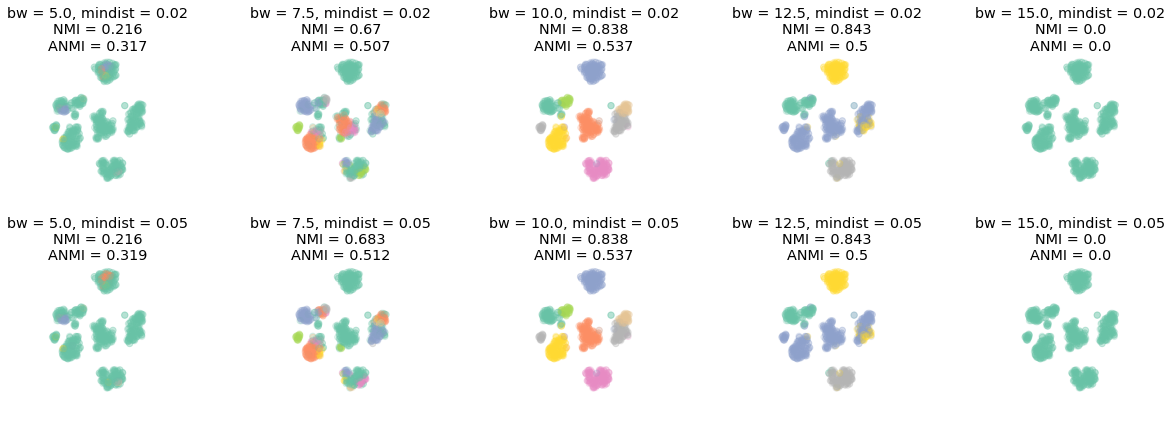

In [26]:
plot_results(data=X_tsne, cl_objects=cl_objects_ms, nmi_arr=nmi_arr_ms, anmi_arr=anmi_vector_ms, consensus_obj=consensus_obj_ms, algorithm='meanshift', arr_x=bw_arr, arr_y=mindist_arr, savetitle = 'img/mnist_ms_all')

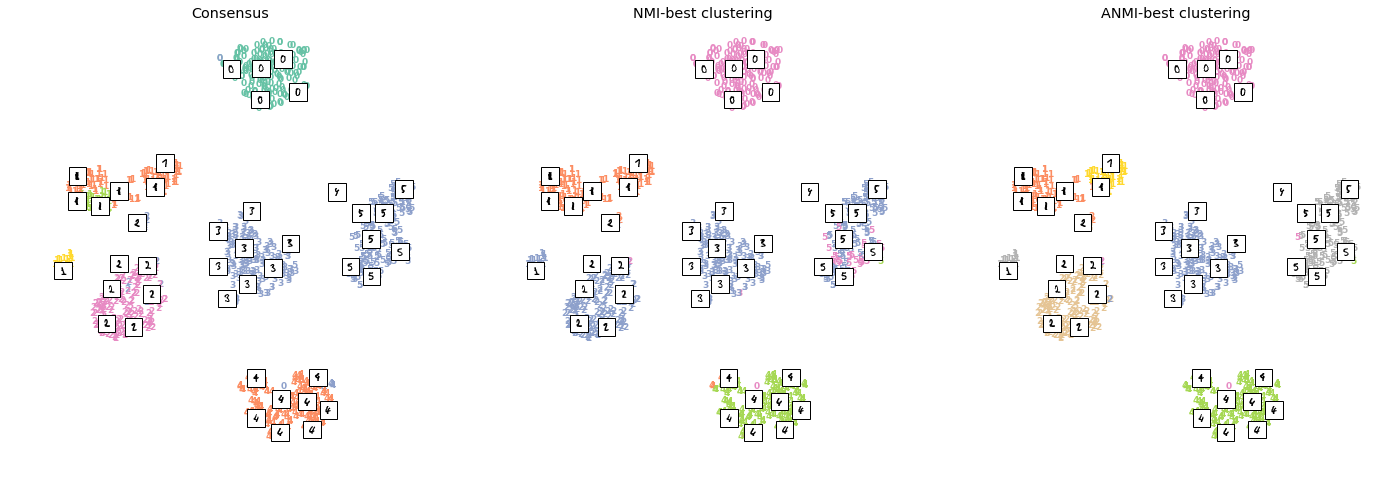

In [27]:
labels_nmi_best = np.array(cl_objects_ms[np.argmax(nmi_arr_ms)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_ms[np.argmax(anmi_vector_ms)].cluster_labels).astype(int)

plot_embedding_cons_par(X_tsne, 
                        consensus_obj_db.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        title_cons="Consensus", title_nmi="NMI-best clustering", title_anmi="ANMI-best clustering", 
                        figsize = (24,8), savetitle_cons='img/mnist_ms_consensus', savetitle_nmi='img/mnist_ms_NMI', savetitle_anmi='img/mnist_ms_ANMI')

In [28]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_ms), " compared to the consensus result, the best parameters are then bandwidth: ",mesh_bw.flatten()[np.argmax(nmi_arr_ms)],", mindist: ", mesh_mindist.flatten()[np.argmax(nmi_arr_ms)])

The best parameter choice (given the chosen range) has NMI  0.842879563042  compared to the consensus result, the best parameters are then bandwidth:  12.5 , mindist:  0.02


# Fuzzy Data (Synthetic)

In [9]:
def old_plot_synth_cons_par(X, labels_cons,labels_par, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    
    #consensus
    ax1=plt.subplot(1, 2, 1)
    ax1.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_cons[i].astype(int)),s=74,alpha=0.2)

    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Consensus Clustering')   
    #parametersearch
    ax2=plt.subplot(1, 2, 2)
    ax2.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_par[i].astype(int)),s=74,alpha=0.2)
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Highest NMI with Consensus Clustering')
    
    if savetitle:
        plt.savefig(savetitle, transparent = True)

In [10]:
def plot_synth_cons_par(X, labels_cons, labels_nmi, labels_anmi, figsize=(16,6), savetitle_cons=None, savetitle_nmi=None, savetitle_anmi=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    num_plots = 3
    fig, axarr = plt.subplots(1, num_plots, figsize=figsize)
    
    #for i, ax in enumerate(axarr.flat):
    for ax in axarr.flat:
        ax.axis('off')
    
    # Consensus
    axarr[0].scatter(X[:, 0], X[:, 1], color=plt.cm.Set2(labels_cons.astype(int)),s=74,alpha=0.2)
    axarr[0].set_title("Consensus Clustering")
    
    # NMI
    axarr[1].scatter(X[:, 0], X[:, 1], color=plt.cm.Set2(labels_nmi.astype(int)),s=74,alpha=0.2)
    axarr[1].set_title("Highest NMI with Consensus Clustering")
    
    # ANMI
    axarr[2].scatter(X[:, 0], X[:, 1], color=plt.cm.Set2(labels_anmi.astype(int)),s=74,alpha=0.2)
    axarr[2].set_title("Highest ANMI with Consensus Clustering")
    
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    extents = [axarr[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted()) for i in range(num_plots)]
    
    if savetitle_cons:
        plt.savefig(savetitle_cons + ".png", transparent = True, bbox_inches=extents[0])
        plt.savefig(savetitle_cons + ".pdf", transparent = True, bbox_inches=extents[0])
    if savetitle_nmi:
        plt.savefig(savetitle_nmi + ".png", transparent = True, bbox_inches=extents[1])
        plt.savefig(savetitle_nmi + ".pdf", transparent = True, bbox_inches=extents[1])
    if savetitle_anmi:
        plt.savefig(savetitle_anmi + ".png", transparent = True, bbox_inches=extents[2])
        plt.savefig(savetitle_anmi + ".pdf", transparent = True, bbox_inches=extents[2])

In [11]:
# Set parameters:

# General
from consensus_clustering.load_data import load_fuzzy_data
fuzzy = load_fuzzy_data()
k_consensus = 10
recluster_what = 'points'
recluster_how = 'hierarchical'
save_image = True

# DBSCAN
n_eps = 6
n_min_pts = 5
eps_arr = np.linspace(0.01, 0.10, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 7
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

np.shape(fuzzy)

(2309, 2)

In [12]:
nmi_arr_db_fz, cl_objects_db_fz, consensus_obj_db_fz = param_search_dbscan(
    data = fuzzy,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 0.1, minPts: 11
Fit consensus
Hierarchical clustering terminated.
Finished after 0:01:03.551399
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.22
Consensus clustering terminated.
Finished after 0:01:31.696177
ANMI (average normalized mutual information) of consensus with clusterings: 0.356
Calculate NMI's


## NMI and ANMI

In [13]:
nmi_matrix, anmi_vector_fz = anmi(consensus_obj_db_fz, cl_objects_db_fz)
print(anmi_vector_fz)
print('entry of anmi maximum: ', np.argmax(anmi_vector_fz), ' and the anmi of that clustering with the rest: ', max(anmi_vector_fz))

[ 0.21796488  0.2915514   0.36776024  0.34360684  0.19150348  0.14683184
  0.2165648   0.29898252  0.36927999  0.36500862  0.27104287  0.14683184
  0.20728904  0.29607139  0.36767837  0.36986387  0.28863271  0.14683184
  0.19037259  0.29236049  0.36195883  0.37228649  0.30294348  0.14052052
  0.17251834  0.28661958  0.35803871  0.37222685  0.32538868  0.1693217 ]
entry of anmi maximum:  21  and the anmi of that clustering with the rest:  0.372286488101


Number of clusterings: 30


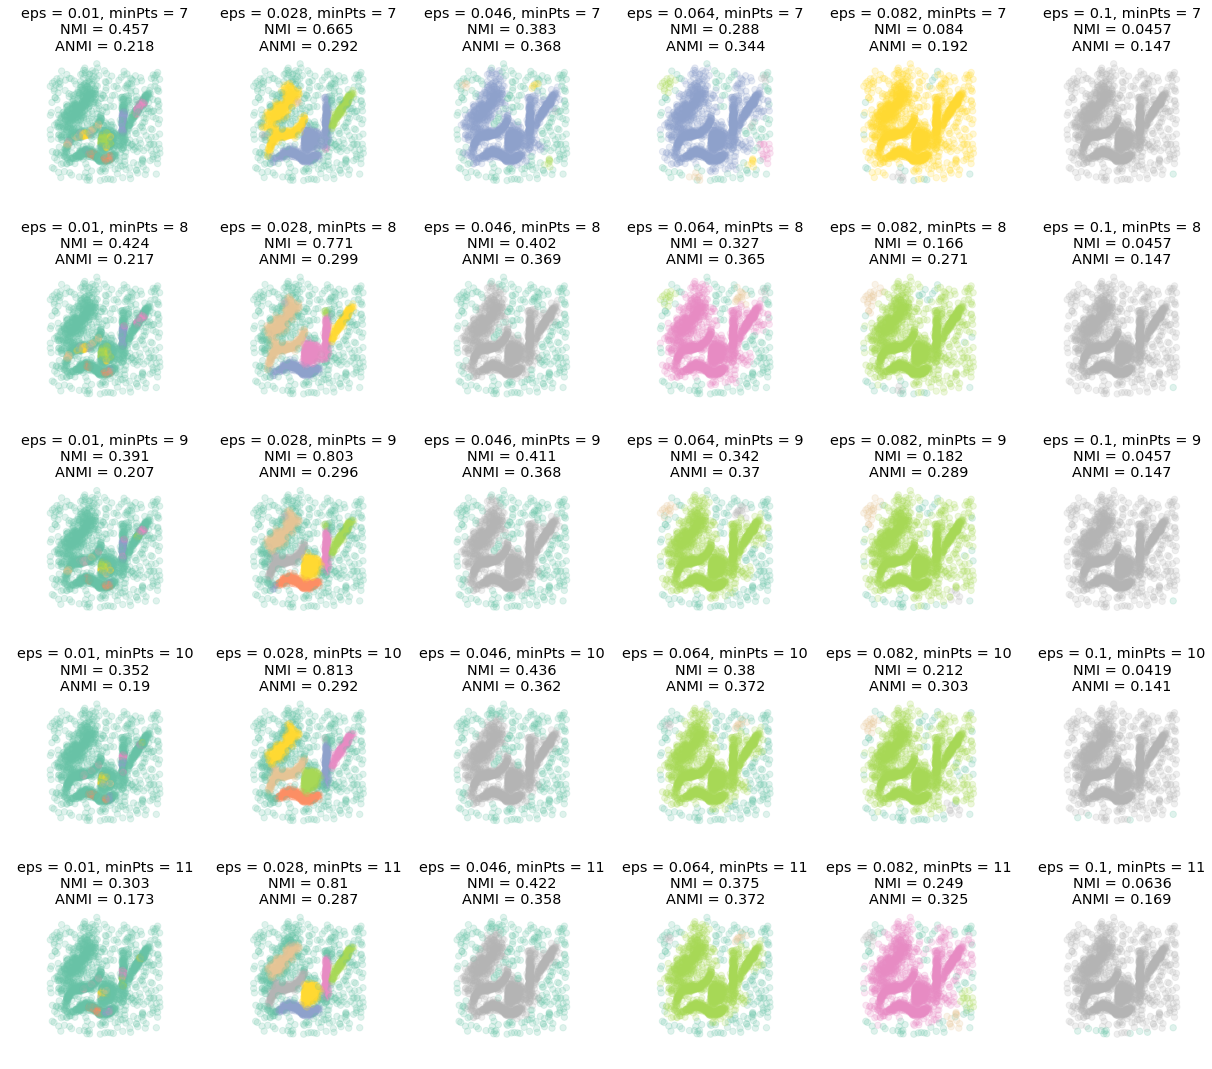

In [14]:
plot_results(data=fuzzy, cl_objects=cl_objects_db_fz, nmi_arr=nmi_arr_db_fz, anmi_arr=anmi_vector_fz, consensus_obj=consensus_obj_db_fz, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr, savetitle = 'img/fuzzy_dbscan_all')

#### The ANMI > 0 in the last column is not a bug:

In [15]:
ind = 5

labels = np.array(cl_objects_db_fz[ind].cluster_labels)
np.unique(labels)

array([-1,  1])

In [16]:
len(fuzzy)

2309

In [17]:
len([i for i, label in enumerate(labels) if label == 1])

2308

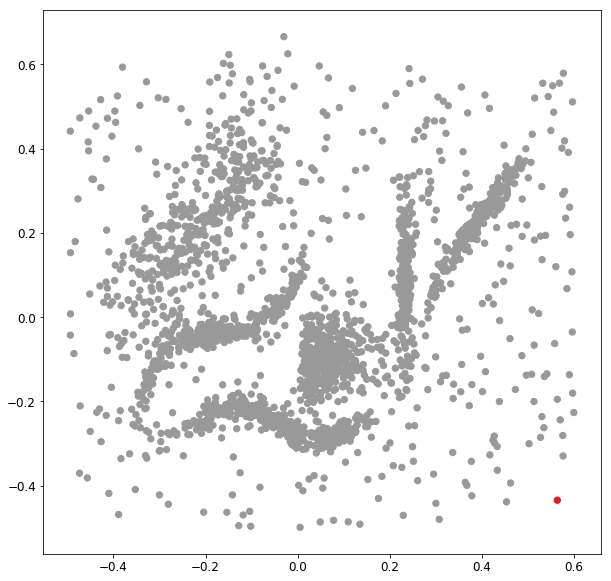

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(fuzzy[:, 0], fuzzy[:, 1], s=40, c=labels.astype(int), cmap='Set1', alpha=1.0)

Note: The one datapoint in the lower right is indeed an own cluster

### Plot best clusterings for fuzzy

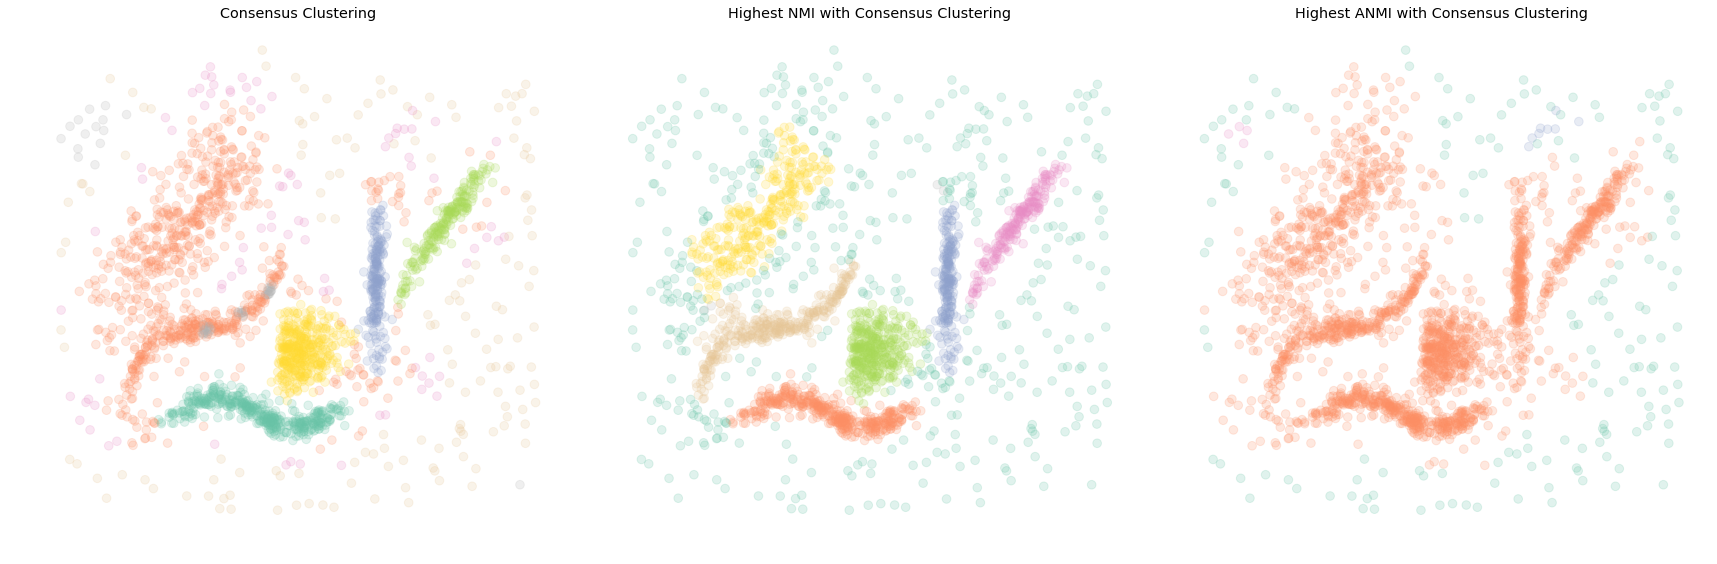

In [19]:
labels_nmi_best = np.array(cl_objects_db_fz[np.argmax(nmi_arr_db_fz)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_db_fz[np.argmax(anmi_vector_fz)].cluster_labels).astype(int)

plot_synth_cons_par(fuzzy, 
                        consensus_obj_db_fz.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        figsize = (24,8), savetitle_cons='img/fuzzy_dbscan_consensus', savetitle_nmi='img/fuzzy_dbscan_NMI', savetitle_anmi='img/fuzzy_dbscan_ANMI')

In [20]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_db_fz), " compared to the consensus result, the best parameters are then eps: ",mesh_eps.flatten()[np.argmax(nmi_arr_db_fz)],", minpts: ", mesh_min_pts.flatten()[np.argmax(nmi_arr_db_fz)])

The best parameter choice (given the chosen range) has NMI  0.813042691197  compared to the consensus result, the best parameters are then eps:  0.028 , minpts:  10


## ROBUSTNESS I: Test NMI-method for different values of $k$, i.e. the number of clusters of the consensus clustering
+ Produce consensus clusterings for the fuzzy dataset for different values of $k$
+ Reuse the DBSCAN-objects from the param-search-function: For every $k$, compute NMI-values with every member of the ensemble
+ Plot NMI-maximizers for every $k$

In [21]:
cons_k_params = np.array([3, 6, 10, 15, 25, 50])
clusterings = cl_objects_db_fz
n_k_params = len(cons_k_params)
n_clusterings = len(clusterings)
consensus_objects = [None]*n_k_params
recluster_what = 'points'
recluster_how = 'hierarchical'

# Fit consensus objects with DBSCAN objects for the different k-values
for i, k_consensus in enumerate(cons_k_params):
    print("\rCompute consensus object {0}/{1}".format(i+1, n_k_params))
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_objects[i] = consensus_obj

# Concatenate NMI's
nmi_array = np.zeros((n_k_params, n_clusterings))
for i, cons in enumerate(consensus_objects):
    nmi_array[i, :] = cons.nmi_arr

Compute consensus object 1/6
Compute consensus object 2/6
Compute consensus object 3/6
Compute consensus object 4/6
Compute consensus object 5/6
Compute consensus object 6/6
Hierarchical clustering terminated.
Finished after 0:01:46.794703
Stopping cluster number was reached.
Current number of clusters: 3
Current minimum cluster distance: 0.39
Consensus clustering terminated.
Finished after 0:01:58.531342
ANMI (average normalized mutual information) of consensus with clusterings: 0.37
Hierarchical clustering terminated.
Finished after 0:01:12.282547
Stopping cluster number was reached.
Current number of clusters: 6
Current minimum cluster distance: 0.26
Consensus clustering terminated.
Finished after 0:01:29.395233
ANMI (average normalized mutual information) of consensus with clusterings: 0.337
Hierarchical clustering terminated.
Finished after 0:01:07.938175
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.22
Consensus clustering

In [22]:
# Pick the winners
maximizer_inds = np.argmax(nmi_array, axis=1)
maximizer_epsilons = mesh_eps.flatten()[maximizer_inds]
maximizer_minPts = mesh_min_pts.flatten()[maximizer_inds]
clusterings_arr = np.array(clusterings)
maximizers = clusterings_arr[maximizer_inds]
nmis_maximizers = np.max(nmi_array, axis=1)

print("The indices of the maximizing clusterings are:")
print(maximizer_inds)
print("The corresponding NMI's with the consensus are:")
print(nmis_maximizers)
print("All NMI's with the corresponding consensus:")
print(nmi_array)

The indices of the maximizing clusterings are:
[20 20 19 19 19 19]
The corresponding NMI's with the consensus are:
[ 0.99591631  0.61748374  0.81304269  0.85796961  0.7775945   0.7568108 ]
All NMI's with the corresponding consensus:
[[ 0.07539639  0.36034583  0.80814431  0.46687134  0.15842764  0.10452548
   0.06731557  0.30143989  0.89302619  0.55093169  0.25648543  0.10452548
   0.05614113  0.25807625  0.92366459  0.57534531  0.28744646  0.10452548
   0.04590334  0.24540229  0.99591631  0.63611338  0.32957304  0.08587242
   0.03959438  0.23297694  0.95871847  0.64612967  0.42311001  0.12226036]
 [ 0.307192    0.37482559  0.51170707  0.33473629  0.10059623  0.06480744
   0.29452642  0.55755491  0.55449907  0.38216195  0.21204771  0.06480744
   0.28238141  0.51800892  0.57319876  0.39362201  0.22865733  0.06480744
   0.2923298   0.51378604  0.61748374  0.40829153  0.26333503  0.05394504
   0.25891047  0.50769725  0.59539208  0.41426363  0.29489055  0.0774441 ]
 [ 0.45701702  0.66500215

In [23]:
def plot_cons_k_results(data, consensus_objs, maximizer_objs, maximizer_x_param, maximizer_y_param,
                        nmis_clusterings, savetitle = None):
    
    # Init plotting arrangement
    n_k_params = len(consensus_objs)
    num_plots = 2 * n_k_params
    num_subplts_per_row = num_plots // 2
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int)
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows, num_cols, figsize=(17, 3*num_rows))
    
    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row #-1
        ax.axis('off')
        ax.set_aspect('equal')
        
        if cur_y == 0:
            ax.scatter(data[:, 0], data[:, 1], s=40, c=consensus_objs[cur_x].cluster_labels.astype(int), cmap='Set2', alpha=0.2)
            ax.set_title('Consensus\nk = {:}\nANMI = {:.3}'.format(consensus_objs[cur_x]._k, consensus_objs[cur_x].anmi))
        elif cur_y == 1:
            ax.scatter(data[:, 0], data[:, 1], s=40, c=maximizer_objs[cur_x].cluster_labels.astype(int), cmap='Set2', alpha=0.2)
            ax.set_title('Best match\neps = {:.3}, minPts = {:}\nNMI = {:.3}'.format(maximizer_x_param[cur_x], maximizer_y_param[cur_x], nmis_clusterings[cur_x]))
            
    plt.tight_layout()
    plt.show()
    if savetitle:
        fig.savefig(savetitle + ".png",transparent = True)
        fig.savefig(savetitle + ".pdf",transparent = True)

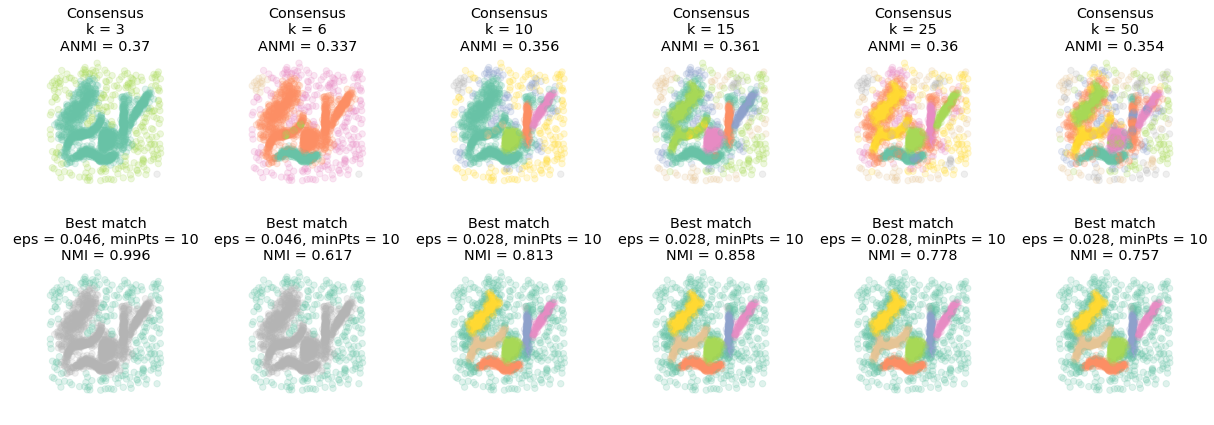

In [24]:
plot_cons_k_results(fuzzy, consensus_objects, maximizers, maximizer_epsilons, maximizer_minPts, nmis_maximizers, savetitle='img/fuzzy_dbscan_k-robustness')

## ROBUSTNESS II: Test Methods on rubbish clusterings (ie. bad hyperparameter choices) and rubbish data sets (ie uniformly distributed points in 2D)  

### (1) Test DBSCAN over a range of hyperparameter with DBSCAN on uniformly placed points

In [41]:
datarandom=np.random.random((1000, 3))
# Set parameters:

# General
k_consensus = 5
recluster_what = 'points'
recluster_how = 'hierarchical'
save_image = True

# DBSCAN
n_eps = 6
n_min_pts = 5
eps_arr = np.linspace(0.01, 0.20, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 7
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

In [42]:
nmi_arr_db_rand, cl_objects_db_rand, consensus_obj_db_rand = param_search_dbscan(
    data = datarandom,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 0.2, minPts: 11
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:03.715249
Stopping cluster number was reached.
Current number of clusters: 5
Current minimum cluster distance: 0.11
Consensus clustering terminated.
Finished after 0:00:05.471426
ANMI (average normalized mutual information) of consensus with clusterings: 0.108
Calculate NMI's


In [43]:
nmi_matrix, anmi_vector_rand = anmi(consensus_obj_db_rand, cl_objects_db_rand)
print(anmi_vector_rand)
print('entry of anmi maximum: ', np.argmax(anmi_vector_rand), ' and the anmi of that clustering with the rest: ', max(anmi_vector_rand))

[ 0.          0.          0.08433895  0.07040976  0.          0.          0.
  0.          0.08207598  0.09167582  0.          0.          0.          0.
  0.06694901  0.09320625  0.          0.          0.          0.          0.
  0.09095123  0.05415602  0.          0.          0.          0.
  0.08116554  0.0540109   0.        ]
entry of anmi maximum:  15  and the anmi of that clustering with the rest:  0.0932062519711


Number of clusterings: 30


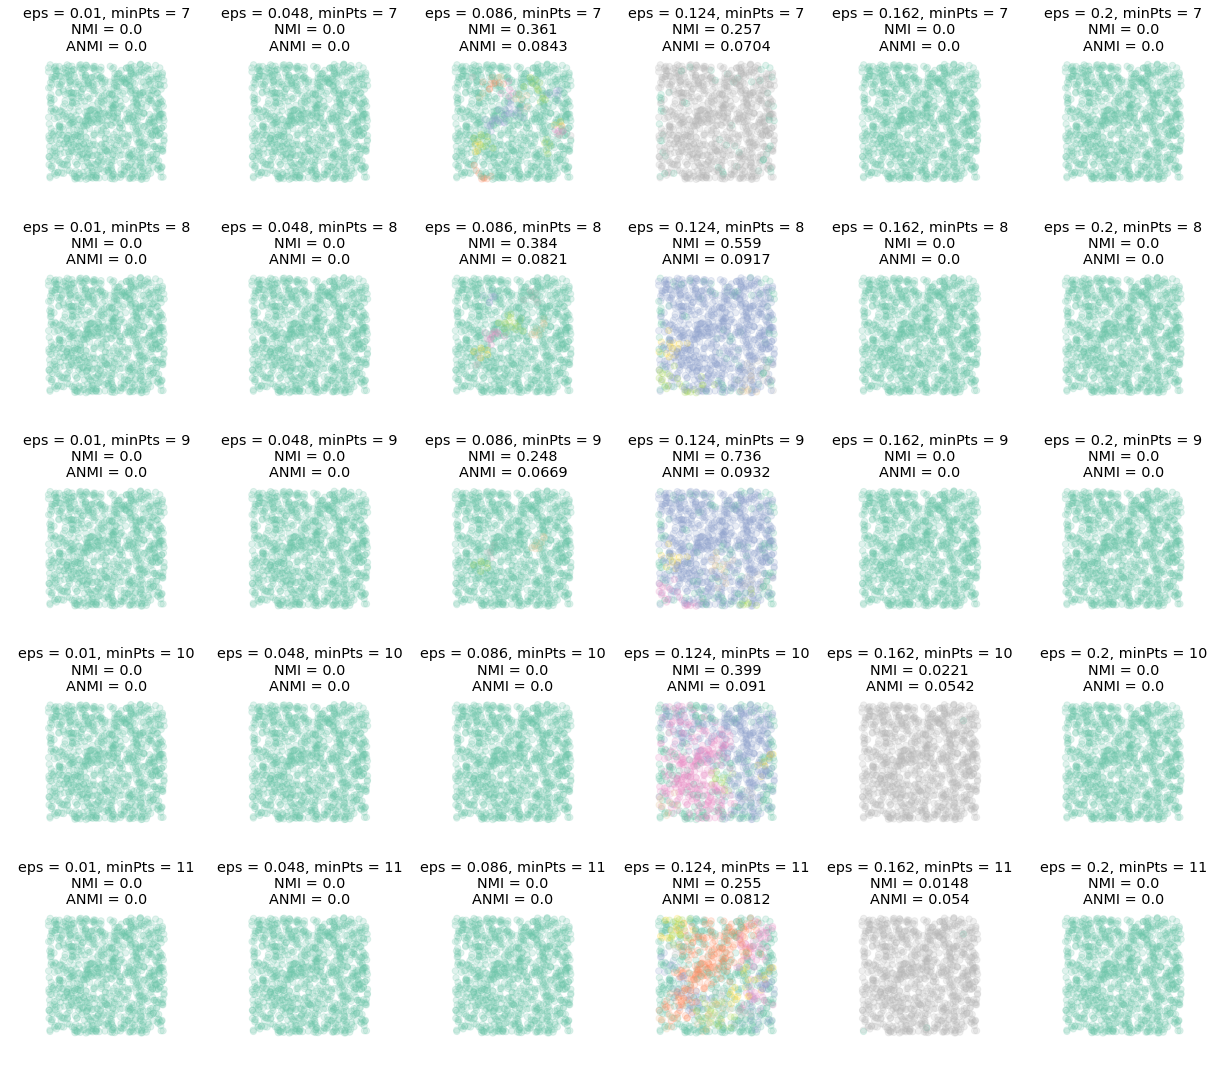

In [44]:
plot_results(data=datarandom, cl_objects=cl_objects_db_rand, nmi_arr=nmi_arr_db_rand, anmi_arr=anmi_vector_rand, consensus_obj=consensus_obj_db_rand, algorithm='dbscan',arr_x=eps_arr, arr_y=min_pts_arr, savetitle = 'img/rand_dbscan_all')

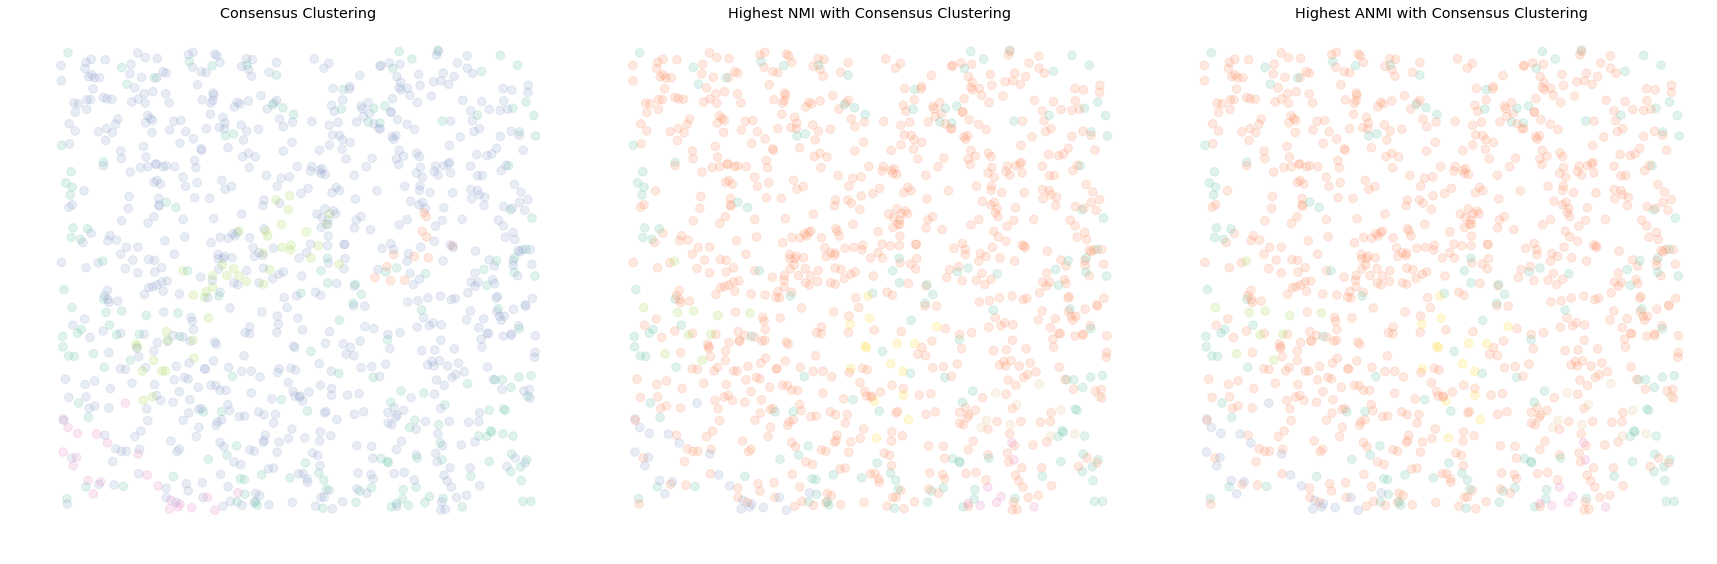

In [45]:
labels_nmi_best = np.array(cl_objects_db_rand[np.argmax(nmi_arr_db_rand)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_db_rand[np.argmax(anmi_vector_rand)].cluster_labels).astype(int)

plot_synth_cons_par(datarandom, 
                        consensus_obj_db_rand.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        figsize = (24,8), savetitle_cons='img/rand_dbscan_consensus', savetitle_nmi='img/rand_dbscan_NMI', savetitle_anmi='img/rand_dbscan_ANMI')

Remark: The ANMI method realizes that it's all rubbish (no clustered points at all), and thus the value is quite low for all clusterings (below 0.1). Because for the consensus clustering procedure we have to set k, the number of clusters, the consensus has to have k clusters. For finding the NMI-best clustering we only compare the clusterings to the consensus, this doesn't work that well here (the consensus itself is bad). The NMI-best clustering has still quite a high NMI with the consensus (around 0.7). So just from the NMI values we can't guess that it's not a good data set (no structure in the data).

### (2) Now let's try K-means and hyperparameter search on the same data

In [46]:
def param_search_kmeans(data, k_consensus, recluster_what, recluster_how, k_arr):
    num_objects = len(k_arr)
    kmeans_objects = [None] * num_objects
    kmeans_obj = None

    print("Fit kmeans objects")

    # Fit kmeans objects
    for i, k in enumerate(k_arr):
        kmeans_obj = cl_dist.KMeans(data=data, k=k, verbose=False)
        kmeans_obj.fit()
        kmeans_objects[i] = kmeans_obj

    print("Fit consensus")

    # Fit consensus
    clusterings = [*kmeans_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(kmeans_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, kmeans_objects, consensus_obj

In [47]:
# Set parameters:

# General
k_consensus = 3
recluster_what = 'points'
recluster_how = 'hierarchical'

#KMeans
km_arr = np.arange(1,6)

nmi_arr_km, cl_objects_km, consensus_obj_km = param_search_kmeans(
    data = datarandom,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    k_arr = km_arr)

Fit kmeans objects
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:03.676380
Stopping cluster number was reached.
Current number of clusters: 3
Current minimum cluster distance: 0.64
Consensus clustering terminated.
Finished after 0:00:03.896659
ANMI (average normalized mutual information) of consensus with clusterings: 0.369
Calculate NMI's


In [48]:
nmi_matrix, anmi_vector_rand_km = anmi(consensus_obj_km, cl_objects_km)
print(anmi_vector_rand_km)
print('entry of anmi maximum: ', np.argmax(anmi_vector_rand_km), ' and the anmi of that clustering with the rest: ', max(anmi_vector_rand_km))

[ 0.          0.32074584  0.36795986  0.42379621  0.42158102]
entry of anmi maximum:  3  and the anmi of that clustering with the rest:  0.423796212987


Number of clusterings: 5


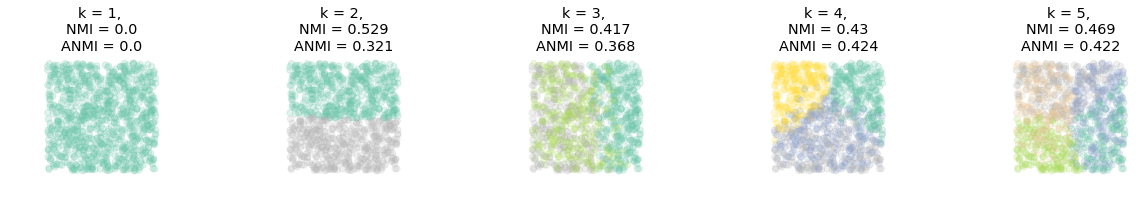

In [49]:
plot_results(data=datarandom, cl_objects=cl_objects_km, nmi_arr=nmi_arr_km, anmi_arr=anmi_vector_rand_km,consensus_obj=consensus_obj_km, algorithm='kmeans',  arr_x=km_arr, arr_y=np.zeros(1), savetitle = 'img/rand_km_all')

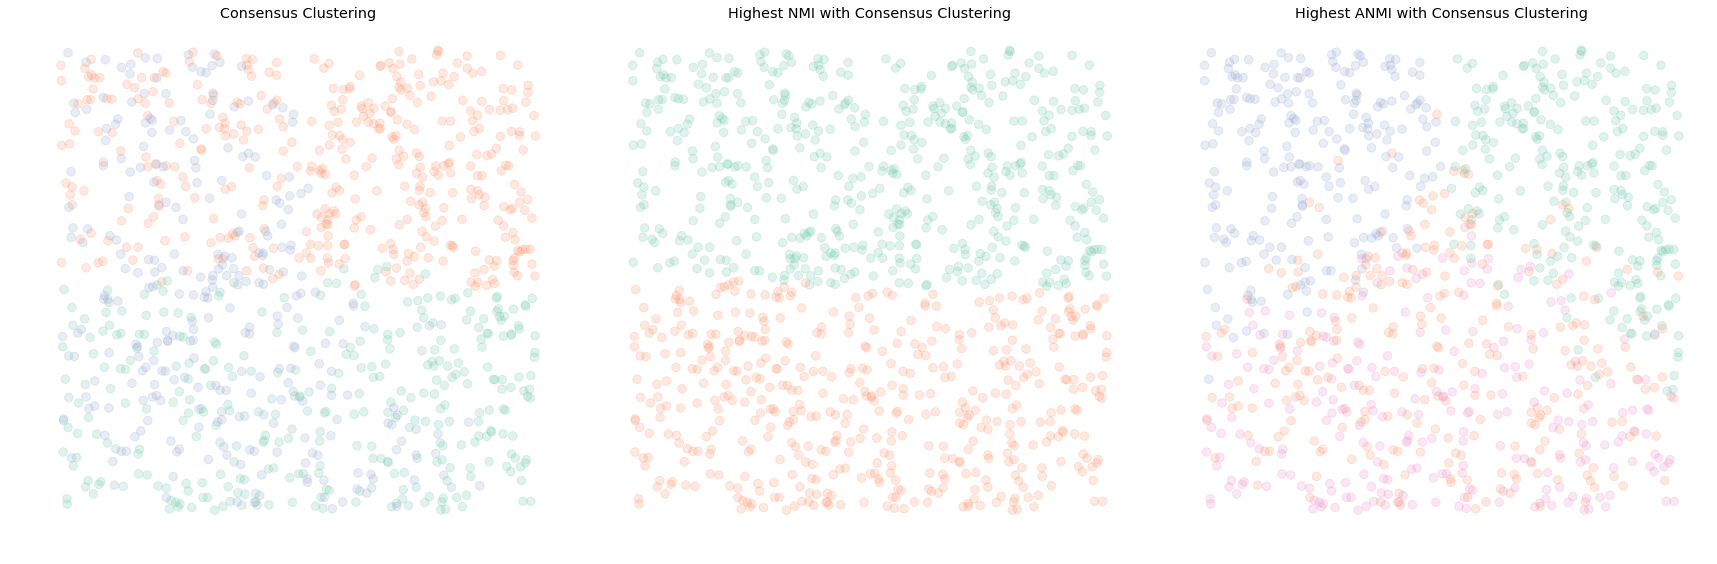

In [50]:
labels_nmi_best = np.array(cl_objects_km[np.argmax(nmi_arr_km)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_km[np.argmax(anmi_vector_rand_km)].cluster_labels).astype(int)

plot_synth_cons_par(datarandom, 
                        consensus_obj_km.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        figsize = (24,8), savetitle_cons='img/rand_km_consensus', savetitle_nmi='img/rand_km_NMI', savetitle_anmi='img/rand_km_ANMI')

Remark: Both NMI-best and ANMI-best methods perform badly. They both don't indicate that the data set or found clusters are rubbish.

### (3) Now a different experiment: what happens if the grid of clusterings doesn't contain any reasonable hyperparameters. We'll take the fuzzy data set and DBCAN again.

In [51]:
# Set parameters:

# General
from consensus_clustering.load_data import load_fuzzy_data
fuzzy = load_fuzzy_data()
k_consensus_bad = 20
recluster_what = 'points'
recluster_how = 'hierarchical'
save_image = True

# DBSCAN
n_eps_bad = 6
n_min_pts_bad = 5
eps_arr_bad = np.linspace(0.001, 0.01, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min_bad = 7
min_pts_arr_bad = np.arange(min_pts_min_bad, min_pts_min_bad + n_min_pts_bad)
mesh_eps_bad, mesh_min_pts_bad = np.meshgrid(eps_arr_bad, min_pts_arr_bad)

In [52]:
nmi_arr_db_bad, cl_objects_db_bad, consensus_obj_db_bad = param_search_dbscan(
    data = fuzzy,
    k_consensus = k_consensus_bad,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps_bad.flatten(),
    min_pts_arr = mesh_min_pts_bad.flatten())

Fit DBSCAN objects
eps: 0.01, minPts: 11
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:45.834647
Stopping cluster number was reached.
Current number of clusters: 20
Current minimum cluster distance: 0.2
Consensus clustering terminated.
Finished after 0:01:31.761902
ANMI (average normalized mutual information) of consensus with clusterings: 0.282
Calculate NMI's


In [53]:
nmi_matrix, anmi_vector_bad_fz = anmi(consensus_obj_db_bad, cl_objects_db_bad)
print(anmi_vector_bad_fz)
print('entry of anmi maximum: ', np.argmax(anmi_vector_bad_fz), ' and the anmi of that clustering with the rest: ', max(anmi_vector_bad_fz))

[ 0.          0.          0.12727783  0.26341914  0.26668732  0.2205907   0.
  0.          0.          0.25832487  0.2784691   0.24005026  0.          0.
  0.          0.23740955  0.28234646  0.25964784  0.          0.          0.
  0.22133191  0.27562007  0.27033934  0.          0.          0.
  0.12881161  0.27024355  0.27354472]
entry of anmi maximum:  16  and the anmi of that clustering with the rest:  0.28234646048


Number of clusterings: 30


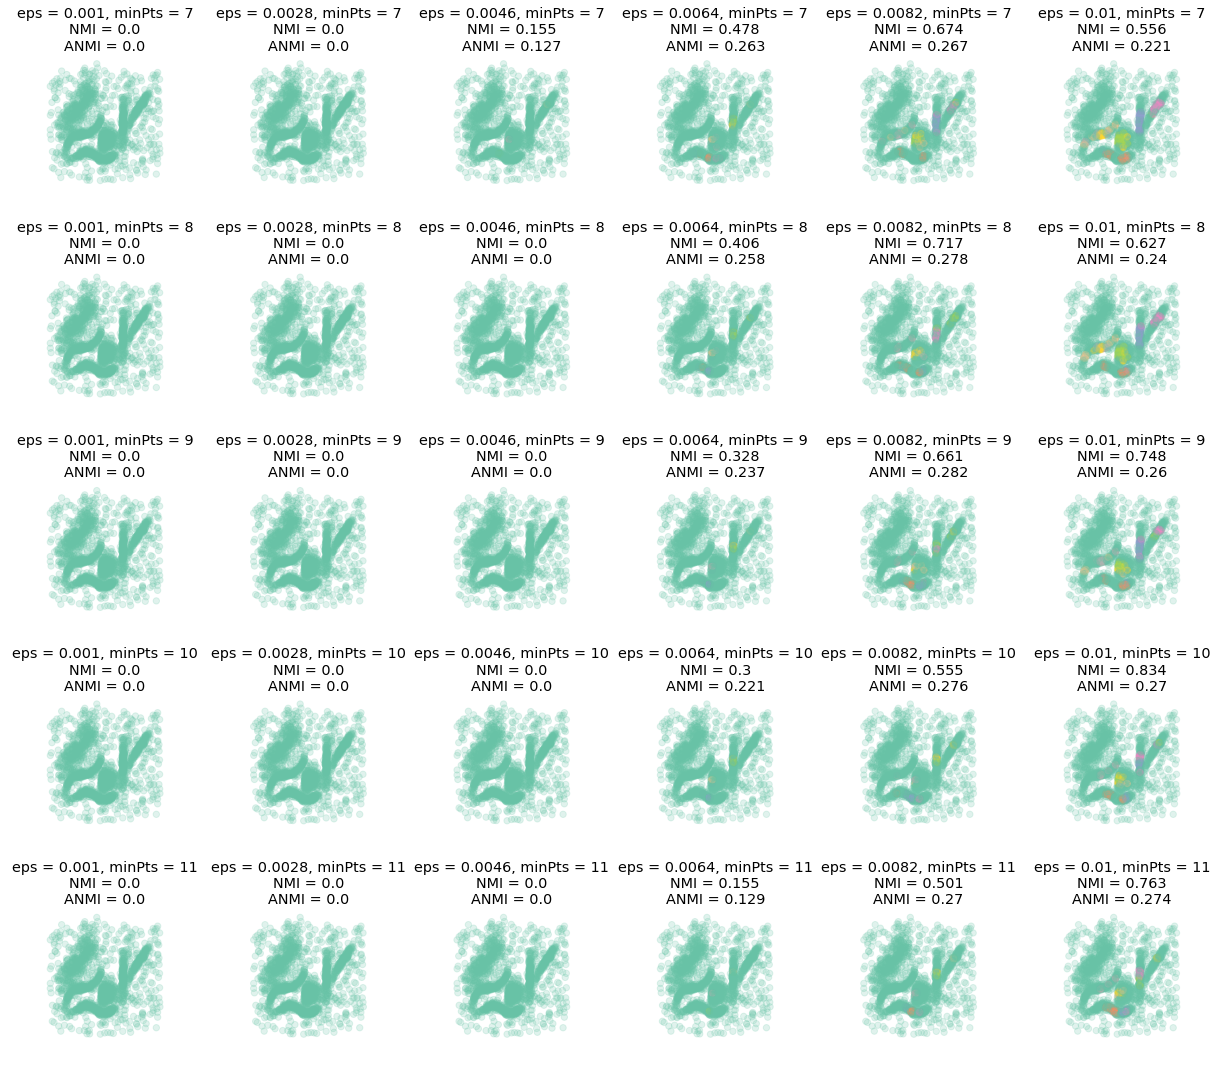

In [54]:
plot_results(data=fuzzy, cl_objects=cl_objects_db_bad, nmi_arr=nmi_arr_db_bad, anmi_arr=anmi_vector_bad_fz, consensus_obj=consensus_obj_db_bad, algorithm='dbscan', arr_x=eps_arr_bad, arr_y=min_pts_arr_bad, savetitle = 'img/fuzzy_baddbscan_all')

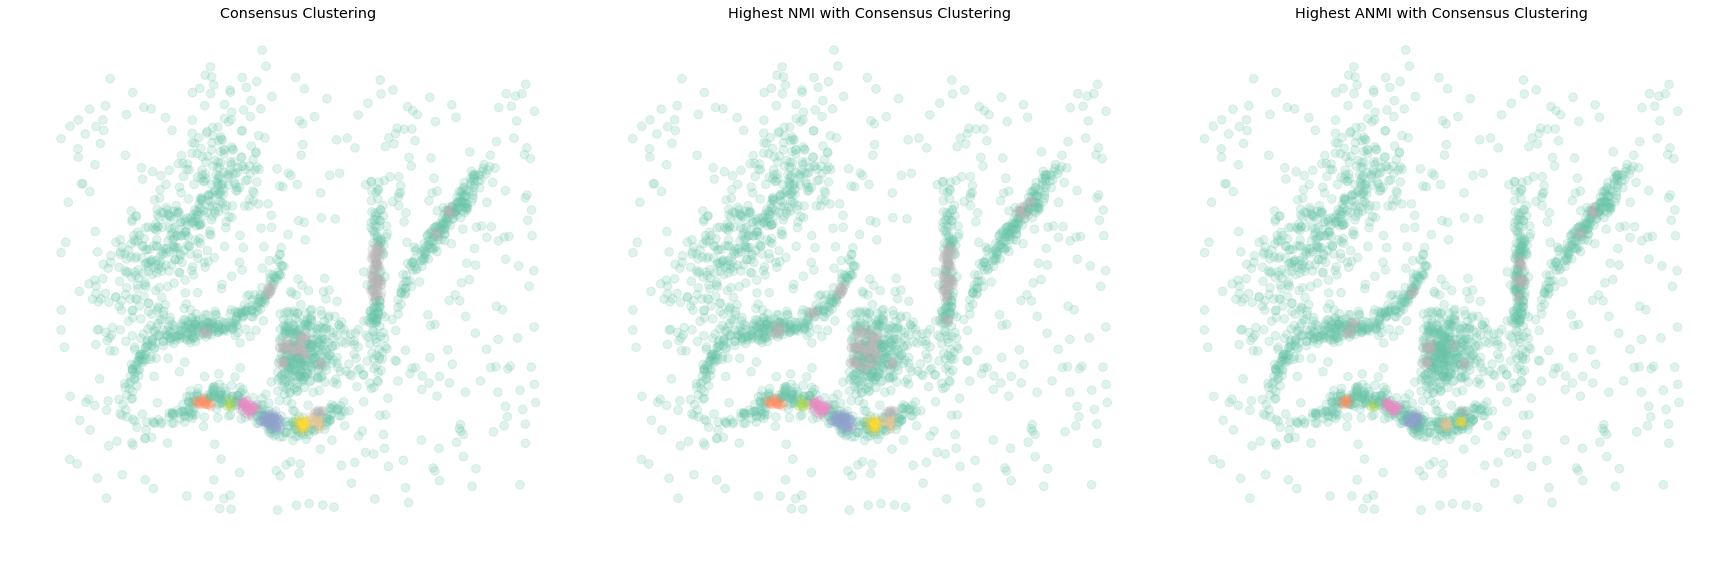

In [55]:
labels_nmi_best = np.array(cl_objects_db_bad[np.argmax(nmi_arr_db_bad)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_db_bad[np.argmax(anmi_vector_bad_fz)].cluster_labels).astype(int)

plot_synth_cons_par(fuzzy, 
                        consensus_obj_db_bad.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        figsize = (24,8), savetitle_cons='img/fuzzy_baddbscan_consensus', savetitle_nmi='img/fuzzy_baddbscan_NMI', savetitle_anmi='img/fuzzy_baddbscan_ANMI')

Remark: Here again the consensus isn't good (not surprising). thus choosing the clustering with the highest NMI doesn't yield a reasonable result. 
But the fact that the ANMI is quite low throughout (below 0.3), indicates that the set of clusterings doesn't contain any good clustering results.